# Project Portfolio Lab: City Tier House Price Forecasting with Random Forests

## Problem Statement

You are a data scientist at a real-estate analytics company. Your team helps investors understand how residential property values evolve over time in different types of cities.

Management has grouped cities into three tiers based on their economic activity and growth potential:

- **Tier 1** – major economic hubs
- **Tier 2** – growing mid-size cities
- **Tier 3** – smaller or emerging cities

You have been given historical data with **average annual house prices** for multiple cities from **2000 to 2020**, along with metadata describing which tier each city belongs to.

**Your task** is to:

1. Select a specific city tier and aggregate its yearly house prices into a single time series.
2. Prepare the data in a format suitable for modeling (`[year, total_price]`).
3. Use **K-fold cross-validation** to train and evaluate **Random Forest regression models**.
4. Select the best model based on test performance and use it to make simple future predictions.

This notebook walks through the entire process step by step, so you can clearly see how the data is transformed at each stage. In your code challenge, you will implement very similar logic inside functions.

## 1. Imports

We start by importing the libraries we will use throughout the notebook.

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

## 2. Load and Inspect the Data

We have two CSV files:

- `city_meta.csv`: metadata for each city (including its tier)
- `house_prices.csv`: annual average house prices per city from 2000 to 2020

Let's load them and take a quick look, with `City_ID` as the index for the `house_prices.csv` data.

In [3]:
city_meta_df = pd.read_csv('city_meta.csv')
prices_df = pd.read_csv('house_prices.csv', index_col=0)
city_meta_df.head()

,City_ID,City_Name,Country,City_Tier
0,C001,Lagos,Nigeria,Tier 1
1,C002,Nairobi,Kenya,Tier 1
2,C003,Johannesburg,South Africa,Tier 1
3,C004,Accra,Ghana,Tier 2
4,C005,Kigali,Rwanda,Tier 2


In [4]:
prices_df.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
City_ID,,,,,,,,,,,,,,,,,,,,,
C001,79352,85017,83710,84054,88004,90968,94849,96516,103229,110093,...,123922,131009,133287,140515,142539,152448,158800,164775,168521,181976
C002,113473,118719,127357,135987,145394,155530,174356,182133,189678,195820,...,229650,241907,249549,257549,277203,299128,320990,332812,354032,375378
C003,121474,130080,136909,145007,155073,156121,162504,168413,173686,181019,...,203132,219286,219283,228149,240778,257166,275634,296107,307955,319227
C004,52802,52384,52194,52339,54709,56604,59495,60539,62665,65744,...,70089,70825,72204,73570,73164,76455,77700,80088,83675,87337
C005,61130,63095,62079,61527,61210,61492,64353,64827,66329,71205,...,77032,77534,79733,80214,82167,87075,85569,89639,93373,94933


In [5]:
city_meta_df['City_Tier'].value_counts()

City_Tier
Tier 2    5
Tier 1    4
Tier 3    3
Name: count, dtype: int64

### Understanding the Relationship Between Tables

- `city_meta_df` tells us **which city belongs to which tier** (`City_Tier`).
- `prices_df` contains **yearly house prices for each city** (one row per `City_ID`).

We will:
1. Choose a `City_Tier` (e.g. `"Tier 1"`),
2. Find all cities in that tier,
3. Aggregate their yearly prices into a 2D array.

## 3. Filter for a Specific City Tier and Aggregate Prices

Let's pick a city tier and make sure it exists in the data.

In [6]:
tier_name = 'Tier 1'
available_tiers = city_meta_df['City_Tier'].unique()
print('Available tiers:', available_tiers)

if tier_name not in available_tiers:
    raise ValueError('Tier not found')

Available tiers: ['Tier 1' 'Tier 2' 'Tier 3']


In [7]:
tier_cities = city_meta_df[city_meta_df['City_Tier'] == tier_name]
tier_city_ids = tier_cities['City_ID']
tier_city_ids

0     C001
1     C002
2     C003
10    C011
Name: City_ID, dtype: object

### Extract Price Data for These Cities

In [8]:
tier_prices_df = prices_df.loc[tier_city_ids]
tier_yearly_prices = tier_prices_df
tier_yearly_prices.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
City_ID,,,,,,,,,,,,,,,,,,,,,
C001,79352,85017,83710,84054,88004,90968,94849,96516,103229,110093,...,123922,131009,133287,140515,142539,152448,158800,164775,168521,181976
C002,113473,118719,127357,135987,145394,155530,174356,182133,189678,195820,...,229650,241907,249549,257549,277203,299128,320990,332812,354032,375378
C003,121474,130080,136909,145007,155073,156121,162504,168413,173686,181019,...,203132,219286,219283,228149,240778,257166,275634,296107,307955,319227
C011,119828,123829,130065,132027,137475,146886,160865,166835,173402,172460,...,186721,194769,201134,212430,213759,216960,243617,248578,255061,284162


### Aggregate Total House Prices Per Year

In [9]:
# Aggregate to get total price per year for this tier
total_price_per_year = tier_yearly_prices.sum(axis=0)
total_price_per_year.head()

2000    434127
2001    457645
2002    478041
2003    497075
2004    525946
dtype: int64

## 4. Build a 2D NumPy Array for Modeling

We want a 2-column NumPy array:

- Column 0: `year` (int)
- Column 1: `total_price` (int)

This structure will later be used by our Random Forest model.

In [10]:
years = total_price_per_year.index.values.astype(int)
prices = total_price_per_year.values.astype(np.int64)
data = np.column_stack((years, prices))
data[:5]

array([[  2000, 434127],
       [  2001, 457645],
       [  2002, 478041],
       [  2003, 497075],
       [  2004, 525946]])

## 5. Visualize the Time Series

Let's quickly plot the total yearly house price for this city tier to see the trend.

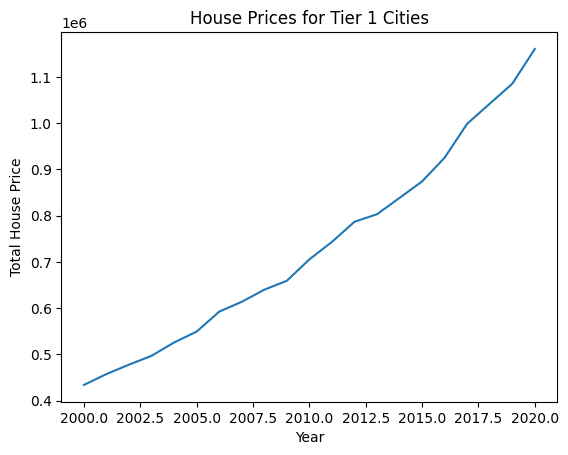

In [11]:
plt.plot(years, prices)
plt.xlabel('Year')
plt.ylabel('Total House Price')
plt.title(f'House Prices for {tier_name} Cities')
plt.show()

## 6. Create K-Fold Train/Test Splits

We'll use `KFold` to generate indices for training and testing sets.
Note: We are working with **indices**, not slices of the data yet.

One way short

In [12]:
kf = KFold(n_splits=5, shuffle=False)
data_indices = [(train, test) for train, test in kf.split(data)]
data_indices[:2]

[(array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
  array([0, 1, 2, 3, 4])),
 (array([ 0,  1,  2,  3,  4,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
  array([5, 6, 7, 8]))]

In [13]:
data_indices

[(array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
  array([0, 1, 2, 3, 4])),
 (array([ 0,  1,  2,  3,  4,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
  array([5, 6, 7, 8])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 13, 14, 15, 16, 17, 18, 19, 20]),
  array([ 9, 10, 11, 12])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 17, 18, 19, 20]),
  array([13, 14, 15, 16])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
  array([17, 18, 19, 20]))]

Another way long

In [14]:
kf = KFold(n_splits=5, shuffle=False)
data_indices = []

# Iterate over the splits generated by kf.split(data)
for train, test in kf.split(data):
    # Append the tuple (train, test) to the data_indices list
    data_indices.append((train, test))

In [15]:
data_indices

[(array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
  array([0, 1, 2, 3, 4])),
 (array([ 0,  1,  2,  3,  4,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
  array([5, 6, 7, 8])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 13, 14, 15, 16, 17, 18, 19, 20]),
  array([ 9, 10, 11, 12])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 17, 18, 19, 20]),
  array([13, 14, 15, 16])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
  array([17, 18, 19, 20]))]

## 7. Train Random Forest Models and Select the Best One

For each fold:

1. Build train and test sets using the indices.
2. Train a `RandomForestRegressor`.
3. Evaluate it using Mean Squared Error (MSE).
4. Track which model gives the **lowest** MSE.

One way

In [16]:
best_model = None
best_mse = None

for i, (train_idx, test_idx) in enumerate(data_indices):
    X_train = data[train_idx, 0].reshape(-1,1)
    y_train = data[train_idx, 1]
    X_test = data[test_idx, 0].reshape(-1,1)
    y_test = data[test_idx, 1]

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    mse = mean_squared_error(y_test, model.predict(X_test))
    print(f'Fold {i+1} MSE:', mse)

    if best_mse is None or mse < best_mse:
        best_mse = mse
        best_model = model

best_mse

Fold 1 MSE: 10086573016.45289
Fold 2 MSE: 1450023019.344576
Fold 3 MSE: 1562421401.9212496
Fold 4 MSE: 3692470382.6015244
Fold 5 MSE: 34162454490.2844


1450023019.344576

Another Way

In [17]:
best_model = None
best_mse = None
best_fold = None

all_results = []

for i, (train_idx, test_idx) in enumerate(data_indices, start=1):
    # Prepare train and test data
    X_train = data[train_idx, 0].reshape(-1, 1)
    y_train = data[train_idx, 1]

    X_test = data[test_idx, 0].reshape(-1, 1)
    y_test = data[test_idx, 1]

    # Define and train the model
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)

    # Evaluate
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    all_results.append({'fold': i, 'mse': mse})
    print(f'Fold {i}: MSE = {mse:.2f}')

    # Update best model (we want the lowest MSE)
    if (best_mse is None) or (mse < best_mse):
        best_mse = mse
        best_model = rf
        best_fold = i

Fold 1: MSE = 10086573016.45
Fold 2: MSE = 1450023019.34
Fold 3: MSE = 1562421401.92
Fold 4: MSE = 3692470382.60
Fold 5: MSE = 34162454490.28


## 8. Recap

In this notebook, we:

1. Loaded two related datasets (`city_meta_df`, `prices_df`).
2. Filtered data for a specific category (`City_Tier`).
3. Aggregated yearly values to build a `[year, total_price]` time series.
4. Converted it into a 2D NumPy array suitable for modeling.
5. Used `KFold` to create train/test splits based on indices.
6. Trained multiple `RandomForestRegressor` models and selected the best one using MSE.